In [1]:
import os
import sys
import time
import uuid

import glob
from pytesseract import Output
import subprocess

from pytesseract import pytesseract
nb_dir = os.path.split(os.getcwd())[0]

sys.path.append(nb_dir)
sys.path.append(os.path.split(nb_dir)[0])

In [2]:
vis_path ="/home/naresh/Tarento/anuvaad/anuvaad-etl/anuvaad-extractor/block-merger/src/notebooks/ocrevaluation/*/*vision.txt"
tes_path  ="/home/naresh/Tarento/anuvaad/anuvaad-etl/anuvaad-extractor/block-merger/src/notebooks/ocrevaluation/*/*tesseract.txt"

for vis,tes in zip(sorted(glob.glob(vis_path)),sorted(glob.glob(tes_path))):
    filename = vis.split('/')[-1].split('_vision.txt')[0]
    out_text_path_vision=vis
    out_text_path_tesseract=tes
    subprocess.run(["java", "-cp","/home/naresh/Tarento/hw-recog-be-lines_ocr_deep_learning_machine_v2/src/ocrevalUAtion-1.3.4-jar-with-dependencies.jar","eu.digitisation.Main","-gt",str(out_text_path_vision),"-ocr",str(out_text_path_tesseract),"-o","/home/naresh/html_file/"+str(filename)+".html"],stdout=subprocess.PIPE)
    
    

In [2]:
base_dir   = os.getcwd()
input_dir  = os.path.join(base_dir, 'sample-data','input')

# OCR evaluation

In [54]:
import pandas as pd
p ="/home/naresh/Tarento/anuvaad/anuvaad-etl/anuvaad-extractor/block-merger/src/notebooks/ocrevaluation/37863_2018_5_1502_16064_Judgement_19-Aug-2019_HIN/37863_2018_5_1502_16064_Judgement_19-Aug-2019_HIN.csv"
d = pd.read_csv(p)

In [19]:
from difflib import SequenceMatcher

def similar(a, b):
    return SequenceMatcher(None, a, b).ratio()



import ast
def post_process(d,image_path):
    word_lis = []
    text_lis = []
    updated_text_lis = []
    image   = Image.open(image_path)
    image   = image.resize((page_width,page_height))
    draw    = ImageDraw.Draw(image)
    for word_coord in d['word_coords']:
        #res = ast.literal_eval(word_coord)
        res=word_coord
        for word in range(len(res)):
            if res[word]['conf']<60 and len(str(res[word]['text']))>1:
                word_lis.append(res[word]); text_lis.append(res[word]['text'])
                left   = res[word]['text_left']; top = res[word]['text_top']
                right  = (res[word]['text_left'] + res[word]['text_width']); bottom = (res[word]['text_top'] + res[word]['text_height'])
                #draw.rectangle(((left, top), (right,bottom)), outline='red')
                crop_image = image.crop((left-5, top-5, right+5, bottom+5)) 
                crop_image.save("/home/naresh/check/"+str(uuid.uuid4())+'.jpg')
                temp_df_eng = pytesseract.image_to_data(crop_image,config='--psm 6', lang= "eng",output_type=Output.DATAFRAME)
                temp_df_hin = pytesseract.image_to_data(crop_image, config='--psm 6',lang= "Devanagari",output_type=Output.DATAFRAME)
                temp_df_eng = temp_df_eng[temp_df_eng['conf']>0]
                temp_df_hin = temp_df_hin[temp_df_hin['conf']>=0]
                org_text  = str(res[word]['text']); eng_text = ""; hin_text =""
                eng_conf =0; hin_conf = 0
                for index,row in temp_df_eng.iterrows():
                    eng_text=eng_text+" "+str(row['text'])
                    eng_conf= eng_conf+row['conf']
                for index,row in temp_df_hin.iterrows():
                    hin_text=hin_text+" "+str(row['text'])
                    hin_conf= hin_conf+row['conf']
                eng_sim = similar(org_text,eng_text)
                hin_sim = similar(org_text,hin_text)
                eng_df_len = len(temp_df_eng); hin_df_len = len(temp_df_hin);
                if eng_df_len==0:
                    eng_df_len=1
                if hin_df_len==0:
                    hin_df_len=1
                 
                if eng_sim>hin_sim:
                    conf = eng_conf/eng_df_len
                    text = eng_text
                elif eng_sim<hin_sim:
                    conf = hin_conf/hin_df_len
                    text = hin_text
                else:
                    if eng_conf>hin_conf:
                        text = eng_text
                        conf = eng_conf/eng_df_len
                    elif eng_conf<hin_conf:
                        conf = hin_conf/hin_df_len
                        text = hin_text
                    else:
                        conf = hin_conf/hin_df_len
                        text = hin_text
                if len(eng_text)==0 and len(hin_text)==0:
                    text  = org_text
                    conf  = res[word]['conf']
                print("original text:",res[word]['text'])
                print("english text", eng_text)
                print("hindi text", hin_text)
                print("final text", text)
            else:
                left   = res[word]['text_left']; top = res[word]['text_top']
                right  = (res[word]['text_left'] + res[word]['text_width']); bottom = (res[word]['text_top'] + res[word]['text_height'])
                #draw.rectangle(((left, top), (right,bottom)), outline='red')
    #image.show()

                



            

In [20]:
post_process(h_df,img_filepath)

original text: 4.0
english text  2.0
hindi text  2.0
final text  2.0
original text: दरभाा
english text  gx
hindi text  दूरभा
final text  दूरभा
original text: B.S.
english text  B.S.
hindi text  B.S.
final text  B.S.
original text: Chauhan
english text  Chauhan
hindi text  Chauhan
final text  Chauhan
original text: India
english text  India
hindi text  India
final text  India
original text: Inada
english text  India
hindi text  India
final text  India
original text: K.(s.
english text  K.G.
hindi text  K.G.
final text  K.G.
original text: Delmi-
english text  Delhi-1
hindi text  Delhi-1
final text  Delhi-1
original text: lelephone
english text  Telephone
hindi text  Telephone
final text  Telephone
original text: 25/30/30,
english text  23736758,
hindi text  23736758,
final text  23736758,
original text: 25353141
english text  23355741.0
hindi text  23355741.0
final text  23355741.0
original text: क॑
english text  ®
hindi text  के
final text  के
original text: अनिवार्य
english text  afar

In [159]:
from difflib import SequenceMatcher

def similar(a, b):
    return SequenceMatcher(None, a, b).ratio()

In [190]:
similar("पी0डब्लूण","पी0०डब्लू0")

0.8421052631578947

In [475]:
import pandas as pd
p ="/home/naresh/Tarento/anuvaad/anuvaad-etl/anuvaad-extractor/block-merger/src/notebooks/char_data.csv"
d = pd.read_csv(p)
d.sort_values('contribution_to_detection_error')
d['contribution_to_detection_error'][-10:].sum()

0.0922673139010679

In [476]:
#updated
import pandas as pd
p ="/home/naresh/Tarento/anuvaad/anuvaad-etl/anuvaad-extractor/block-merger/src/notebooks/char_data.csv"
d = pd.read_csv(p)
d.sort_values('contribution_to_detection_error')
d['contribution_to_detection_error'][-10:].sum()

0.0922673139010679

In [472]:
#updated
import pandas as pd
p ="/home/naresh/Tarento/anuvaad/anuvaad-etl/anuvaad-extractor/block-merger/src/notebooks/char_data.csv"
d = pd.read_csv(p)
d.sort_values('contribution_to_detection_error')
d['contribution_to_detection_error'][-10:].sum()

0.0802239669789313

In [473]:
(((d['contribution_to_overall_error']*d['total_detected_chars']).sum())/(d['total_detected_chars'].sum()))*len(d)

7.430841576059978

In [474]:
(((d['contribution_to_detection_error']*d['total_detected_chars']).sum())/(d['total_detected_chars'].sum()))*len(d)

4.071269722341124

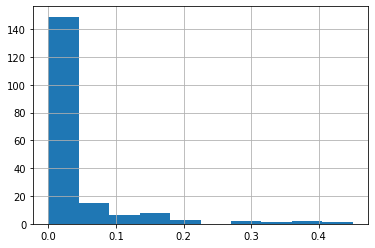

In [31]:
d['contribution_to_overall_error'].hist(

In [72]:
k=[]
import shutil
for i in glob.glob(base_dir+'/ocrevaluation/*/*.html'):
    k.append(i.split('/')[-1].split('.html')[0])
    #
for i in glob.glob(input_dir+'/*.pdf'):
    if i.split('/')[-1].split('.pdf')[0] in k:
        os.remove(i)
        

In [469]:
import shutil

In [470]:
for i in glob.glob(base_dir+'/ocrevaluation/*/*.html'):
    shutil.copy(i,base_dir+'/html_file/')

In [3]:
import pandas as pd
from PIL import Image, ImageDraw
import copy
from google.oauth2 import service_account
from google.cloud import vision

In [4]:
from services.xml_document_info import (get_xml_info, get_xml_image_info)
from services.get_xml import  create_pdf_processing_paths, extract_pdf_metadata, process_input_pdf
from anuvaad_auditor.loghandler import log_info
from anuvaad_auditor.loghandler import log_error
from src.services import main
from src.services.get_underline import get_underline
from services import get_xml
from src.services.child_text_unify_to_parent import ChildTextUnify
from services.preprocess import prepocess_pdf_regions
from services.get_tables import page_num_correction , get_text_table_line_df
from src.services.ocr_text_utilities import  tesseract_ocr
import src.utilities.app_context as app_context
import config

In [5]:
def draw_box(filepath, desired_width, desired_height, df, color="green", save=False):
    image  = Image.open(filepath)
    image  = image.resize((desired_width, desired_height))
    draw   = ImageDraw.Draw(image)
    
    for index, row in df.iterrows():
        left   = int(row['text_left'])
        right  = int(row['text_width'] + left)
        top    = int(row['text_top'])
        bottom = int(row["text_height"] + top)
        
        draw.rectangle(((left, top), (right,bottom)), outline=color)
    save_filepath = os.path.join(os.path.dirname(filepath), 'processed_' + os.path.basename(filepath))
    if save:
        image.save(save_filepath)
    
    return image

def show_df(df):
    return df.head(df.shape[0])

In [6]:
app_context.application_context= dict({'input': {'files': [{'locale': 'hi', 'path': 'RTIOrder_hi.pdf', 'type': 'pdf'}]}, 'jobID': 'BM-15913540488115873', 'state': 'INITIATED', 'status': 'STARTED', 'stepOrder': 0, 'workflowCode': 'abc', 'tool': 'BM', 'metadata': {'module': 'WORKFLOW-MANAGER', 'receivedAt': 15993163946431696, 'sessionID': '4M1qOZj53tIZsCoLNzP0oP', 'userID': 'd4e0b570-b72a-44e5-9110-5fdd54370a9d'}, 'taskID': 'BM-16000776881221366'})

## start of the program

In [23]:
'''
  folder structure of test data goes like this
  - notebooks
      - sample-data
          - input
          - output
          
  the pdfs are present in "input" directory and they are *.pdf is added into .gitignore
  just to save repo size.
'''

base_dir   = os.getcwd()
input_dir  = os.path.join(base_dir, 'sample-data','input')
save_dir   = os.path.join(base_dir, 'sample-data', 'bbox_output')
output_dir = os.path.join(base_dir, 'sample-data', 'output')



filename = '37863_2018_5_1502_16064_Judgement_19-Aug-2019_HIN.pdf'
#filename   = 'SC_2011_CA1025_ta.pdf'
#filename = 'SC_2009_CA2062_ta.pdf'
#filename = 'SC_2017_CA2502_ta.pdf'
#special error filename = 'ma_hc_2000_SA2034_ta.pdf'

#filename = 'ma_hc_2001_SA725_ta.pdf'
#error filename = 'ma_hc_2007_CMA1134_ta.pdf'
# error filename = 'SC_2019_CA117_ta.pdf'
lang ='hi'
index = 1

#correct output = ['SC_2011_CA1025_ta.pdf','SC_2009_CA2062_ta.pdf','SC_2017_CA2502_ta.pdf','ma_hc_2001_SA725_ta.pdf']
#wrong output = ['ma_hc_2017_WA1248_alt_ta.pdf','ma_hc_2000_SA2034_ta.pdf','ma_hc_2007_CMA1134_ta.pdf','SC_2019_CA117_ta.pdf']


## extract the pdf into xml & background images for downstream processing

In [24]:
pdf_filepath      = os.path.join(input_dir, filename)

img_dfs,xml_dfs, page_width, page_height,working_dir, pdf_bg_img_filepaths, pdf_image_paths  = get_xml.process_input_pdf(filename, input_dir, lang)
#img_dfs, xml_dfs, page_width, page_height, working_dir, pdf_bg_img_filepaths = get_xml.process_input_pdf(pdf_filepath, output_dir, 'JOBID_1000')
#header_region, footer_region = prepocess_pdf_regions(xml_dfs, page_height)


[2020-09-29 16:45:43,044] {loghandler.py:20} MainThread INFO in loghandler: created processing directories successfully /home/naresh/Tarento/anuvaad/anuvaad-etl/anuvaad-extractor/block-merger/src/notebooks/sample-data/input/37863_2018_5_1502_16064_Judgement_19-Aug-2019_HIN_1d2d43ac-0245-11eb-833a-38baf82f7425
[2020-09-29 16:45:43,046] {loghandler.py:20} MainThread INFO in loghandler: filepath /home/naresh/Tarento/anuvaad/anuvaad-etl/anuvaad-extractor/block-merger/src/notebooks/sample-data/input/37863_2018_5_1502_16064_Judgement_19-Aug-2019_HIN.pdf, working_dir /home/naresh/Tarento/anuvaad/anuvaad-etl/anuvaad-extractor/block-merger/src/notebooks/sample-data/input/37863_2018_5_1502_16064_Judgement_19-Aug-2019_HIN_1d2d43ac-0245-11eb-833a-38baf82f7425
[2020-09-29 16:45:43,657] {loghandler.py:20} MainThread INFO in loghandler: Extracting xml of /home/naresh/Tarento/anuvaad/anuvaad-etl/anuvaad-extractor/block-merger/src/notebooks/sample-data/input/37863_2018_5_1502_16064_Judgement_19-Aug-201

# Draw Bounding box using dfs

In [29]:
def doc_structure_analysis(xml_dfs,img_dfs,working_dir ,lang, page_width, page_height, pdf_bg_img_filepaths,pdf_image_paths):
    
    '''
        Document structure analysis to get:
            - in_dfs
            - table_dfs
            - line_dfs
            - h_dfs
            - v_dfs
            - p_dfs
            - text_block_dfs

    '''
    log_info("document structure analysis started  ===>", app_context.application_context )

    header_region, footer_region = prepocess_pdf_regions(xml_dfs, page_height)
    text_merger = ChildTextUnify()
    
    in_dfs, table_dfs, line_dfs,bg_dfs = get_text_table_line_df(xml_dfs, img_dfs, pdf_bg_img_filepaths,check=True)
    #in_dfs[0]['font_family']="times"
    #in_dfs[0]['font_family_updated']="times"
    h_dfs                              = get_xml.get_hdfs(in_dfs,header_region,footer_region)
    
    if lang != 'en':
        h_dfs = tesseract_ocr(pdf_image_paths, page_width, page_height, h_dfs, lang)
        for h_df in h_dfs:
            h_df['children'] = None
    v_dfs                              = get_xml.get_vdfs(h_dfs)
    p_dfs                              = get_xml.get_pdfs(v_dfs, lang)
    p_dfs , line_dfs                   = get_underline(p_dfs,line_dfs,app_context.application_context)
    
    
    if lang=='en':
        p_dfs  = text_merger.unify_child_text_blocks(p_dfs)
    
    
    log_info( "document structure analysis successfully completed", app_context.application_context )
    return in_dfs,h_dfs, v_dfs, p_dfs

In [30]:
in_dfs,h_dfs, v_dfs, p_dfs = doc_structure_analysis([xml_dfs[index]],[img_dfs[index]],working_dir, lang, page_width, page_height, [pdf_bg_img_filepaths[index]],[pdf_image_paths[index]])

[2020-09-29 16:46:06,686] {loghandler.py:20} MainThread INFO in loghandler: document structure analysis started  ===>
[2020-09-29 16:46:06,882] {loghandler.py:20} MainThread INFO in loghandler: Header Footer detection completed successfully  in time 0.1891188621520996 
[2020-09-29 16:46:06,882] {loghandler.py:20} MainThread INFO in loghandler: Footers found 41 
[2020-09-29 16:46:06,883] {loghandler.py:20} MainThread INFO in loghandler: Headers found 5
[2020-09-29 16:46:06,884] {loghandler.py:20} MainThread INFO in loghandler: TableExtractor service started
[2020-09-29 16:46:07,238] {loghandler.py:20} MainThread INFO in loghandler: Processing of get_hdfs completed in 0.27103257179260254/1, average per page 0.27103257179260254
[2020-09-29 16:46:07,239] {loghandler.py:20} MainThread INFO in loghandler: tesseract ocr started  ===>
kkkkkkkkkkkkkkkkkkkkkkk
kkkkkkkkkkkkkkkkkkkkkkk
kkkkkkkkkkkkkkkkkkkkkkk
kkkkkkkkkkkkkkkkkkkkkkk
kkkkkkkkkkkkkkkkkkkkkkk
kkkkkkkkkkkkkkkkkkkkkkk
kkkkkkkkkkkkkkkkk

In [31]:
page_index_path      = 1
page_index = 0
img_filepath    = pdf_image_paths[page_index_path]

in_df   = in_dfs[page_index]
h_df    = h_dfs[page_index]
v_df    = v_dfs[page_index]
p_df    = p_dfs[page_index]
#ocr_df  = ocr_dfs[page_index]

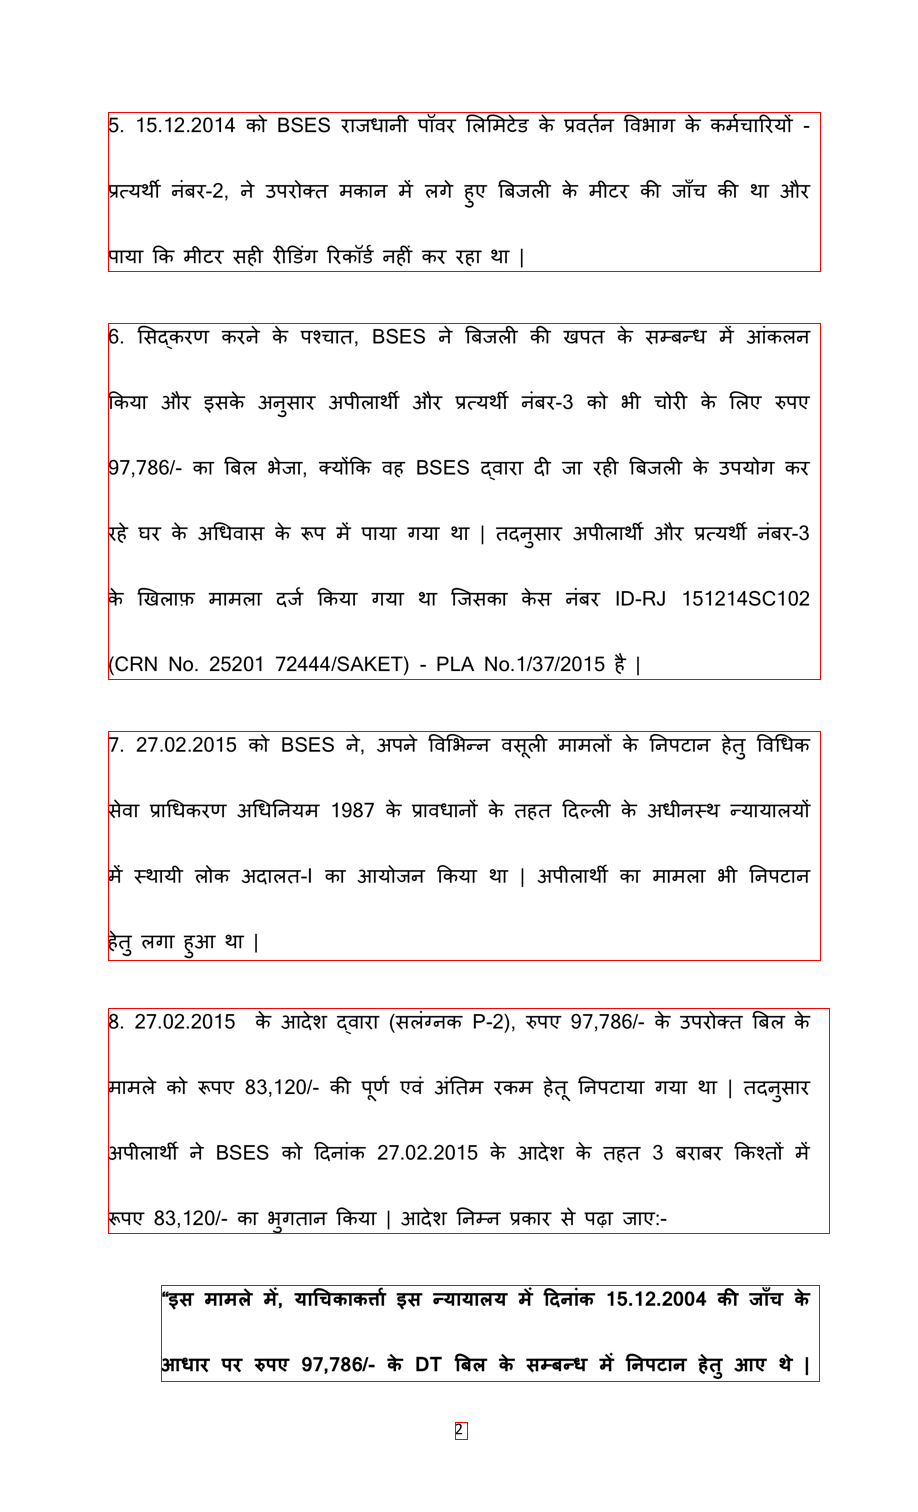

In [32]:
draw_box(img_filepath, page_width, page_height,p_df, color='red')

# Draw bounding box for json response 

In [8]:
from src.services import main

In [9]:
pdf_path = input_dir+"/"+filename
save_path  = save_dir+"/"+str(filename.split('.pdf')[0])
if not os.path.exists(save_path):
    os.system('mkdir -p {0}'.format(save_path))
data = main.DocumentStructure(app_context, filename, lang='hi',base_dir=input_dir)

[2020-09-14 19:15:28,740] {loghandler.py:48} MainThread DEBUG in loghandler: Block merger starting processing {'input': {'files': [{'locale': 'hi', 'path': 'RTIOrder_hi.pdf', 'type': 'pdf'}]}, 'jobID': 'BM-15913540488115873', 'state': 'INITIATED', 'status': 'STARTED', 'stepOrder': 0, 'workflowCode': 'abc', 'tool': 'BM', 'metadata': {'module': 'WORKFLOW-MANAGER', 'receivedAt': 15993163946431696, 'sessionID': '4M1qOZj53tIZsCoLNzP0oP', 'userID': 'd4e0b570-b72a-44e5-9110-5fdd54370a9d'}, 'taskID': 'BM-16000776881221366'}
[2020-09-14 19:15:28,742] {loghandler.py:20} MainThread INFO in loghandler: document preprocessing started ===>
[2020-09-14 19:15:28,743] {loghandler.py:20} MainThread INFO in loghandler: created processing directories successfully /home/naresh/Tarento/anuvaad/anuvaad-etl/anuvaad-extractor/block-merger/src/notebooks/sample-data/input/report_001_hi_8cdffdea-f690-11ea-8d07-38baf82f7425
[2020-09-14 19:15:28,744] {loghandler.py:20} MainThread INFO in loghandler: filepath /home/

KeyboardInterrupt: 

In [66]:
response = data['result']

In [67]:
def draw_bbox_image(draw,page_data):
    
    if page_data['images']:
        try:
            for image_block in page_data['images']:
                    top     = image_block["text_top"];         left   = image_block["text_left"];  
                    bottom  = top+image_block["text_height"];  right  = left+image_block["text_width"]
                    draw.rectangle(((left, top), (right,bottom)), outline='green')
            return draw
        except:
            pass

In [68]:
def draw_bbox_table(draw,page_data):
    
    if page_data['tables']:
        try:
            for table_block in page_data['tables']:
                    top     = table_block["text_top"];         left   = table_block["text_left"];  
                    bottom  = top+table_block["text_height"];  right  = left+table_block["text_width"]
                    draw.rectangle(((left, top), (right,bottom)), outline='blue')
            return draw
        except:
            pass

In [69]:
def draw_bbox_text(draw,page_data):
    
    if page_data['text_blocks']:
        try:
            for text_block in page_data['text_blocks']:
                top     = text_block["text_top"];         left   = text_block["text_left"];  
                bottom  = top+text_block["text_height"];  right  = left+text_block["text_width"]
                draw.rectangle(((left, top), (right,bottom)), outline='red')
            return draw
        except:
            pass

In [70]:
def draw_bbox_pdf(data,image_files,save_path):
    for page_no in range(len(data)):
        image_path = sorted(image_files)[page_no]
        page_data = data[page_no]
        page_width = page_data['page_width']; page_height = page_data['page_height']
        image  = Image.open(image_path)
        image  = image.resize((page_width, page_height))
        draw   = ImageDraw.Draw(image)
        draw  = draw_bbox_text(draw,page_data)
        draw  = draw_bbox_image(draw,page_data)
        draw  = draw_bbox_table(draw,page_data)
        save_filepath = os.path.join(save_path,image_path.split('images/')[1])
        image.save(save_filepath)
            

In [71]:
draw_bbox_pdf(response,pdf_image_paths,save_path)